# **Association between Abstract Characteristics and Ranking Position in Technology-Assisted Reviewing (TAR): coding set-up**

### **by Isa Spiero <br>**

#### **Part I: Data**

The datasets are imported. These are the datasets based on the previously conducted systematic reviews by Andaur Navarro et al. and Heus et al., respectively. The titles and abstract of each record along with the title-abstract level inclusions, full-text level inclusions, and abstract characteristics are present in the dataset. The abstract characterstics consist of: (a) TRIPOD scores, (b) abstract structural components, and (c) abstract language usage.

#### **Part II: Ranking** 

A screening tool (ASReview) is used to simulate the title-abstract screening by using active learning to rank and prioritize records that are most likely to be relevant for the review. These ranking algorithms use a feature extractor and classifier to compute rankings. The simulation is continued until all records have passed, and the final ranking is saved.

#### **Part III: Evaluation**

In the evaluation, the association between abstract characteristics (as described under Data) and the ranking position (as computed with the tool during Ranking) is examined.

------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
from pathlib import Path

import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

#### **Part I: Data**
Load the data that were preprocessed with the data_preprocessing.ipynb notebook:

In [4]:
path_output = "./output/output/simulations_original_datasets/"
path_data = "./data/processed/"

In [5]:
review_dic = {}

for file_name in os.listdir(path_data):
    if file_name.endswith('.csv'):
        file_path = os.path.join(path_data, file_name)
        df = pd.read_csv(file_path)
        key = os.path.splitext(file_name)[0].split("_")[0]
        review_dic[key] = df

review_dic = dict(sorted(review_dic.items()))

In [6]:
for key, df in review_dic.items():
    df.rename(columns={'Unnamed: 0': 'record_id'}, inplace=True)

#### **Part II: Ranking**

Load rankings of previous study

In [9]:
# Specify the the classification, feature extraction, and query model(s) that were tested
train_models = ['logistic', 'nb', 'svm'] 
feature_models = ['tfidf', 'sbert'] 
query_models = ['max']

# Specify the number of simulations per review-model combination  
n_simulations = 200 

In [10]:
# Create a list of the review-model combination names
sim_list_names = []
for review in review_dic:
    for train_model in train_models:
        for feature_model in feature_models:
            for query_model in query_models:
                review_id = str(review + "_" + train_model + "_" + feature_model + "_" + query_model )
                sim_list_names.append(review_id)
             
# Retrieve the output from the HPC generated pickle files with each having the rankings of a single simulation
multiple_sims = []
for i in range(0, len(sim_list_names)):
    raw_output = {}
    for j in range(1,n_simulations+1):
        if Path(path_output +'sim_{review_id}_{sim}.p'.format(review_id=sim_list_names[i], sim=j)).is_file():
            with open(path_output + 'sim_{review_id}_{sim}.p'.format(review_id=sim_list_names[i], sim=j),'rb') as f:
                raw_output.update(pickle.load(f))
    if len(raw_output) > 0:
        multiple_sims.append((sim_list_names[i], len(review_dic[sim_list_names[i].split('_')[0]]), n_simulations, raw_output))

Merge the rankings with the datasets

In [19]:
warnings.filterwarnings('ignore', category=FutureWarning)

review_dic_merged = review_dic.copy()

for i in review_dic:
    for j in range(0, len(multiple_sims)):
        if multiple_sims[j][0].split('_')[0] == i:

            for k in multiple_sims[j][3]:          

                review_sim = multiple_sims[j][0] + "_" + str(j)
                review_key = multiple_sims[j][0].split('_')[0]
                index_list = multiple_sims[j][3][k][0]['record_id']
                review_dic_merged[review_key][review_sim] = review_dic_merged[review_key]['record_id'].map({val: idx for idx, val in enumerate(index_list)})
            
    review_dic_merged[review_key]['ranking_average_logistic_tfidf'] = review_dic_merged[review_key].filter(like='logistic_tfidf').mean(axis=1)
    review_dic_merged[review_key]['ranking_average_logistic_sbert'] = review_dic_merged[review_key].filter(like='logistic_sbert').mean(axis=1)
    review_dic_merged[review_key]['ranking_average_nb_tfidf'] = review_dic_merged[review_key].filter(like='nb_tfidf').mean(axis=1)
    review_dic_merged[review_key]['ranking_average_svm_sbert'] = review_dic_merged[review_key].filter(like='svm_sbert').mean(axis=1)
    review_dic_merged[review_key]['ranking_average_svm_tfidf'] = review_dic_merged[review_key].filter(like='svm_tfidf').mean(axis=1)

In [21]:
warnings.filterwarnings('ignore', category=FutureWarning)

review_dic_merged = review_dic.copy()

for i in range(0, len(multiple_sims)):
    for j in multiple_sims[i][3]:

        review_sim = multiple_sims[i][0] + "_" + str(j)
        review_key = multiple_sims[i][0].split('_')[0]
        index_list = multiple_sims[i][3][j][0]['record_id']
        review_dic_merged[review_key][review_sim] = review_dic_merged[review_key]['record_id'].map({val: idx for idx, val in enumerate(index_list)})
    
    #review_dic_merged[review_key]['ranking_average'] = review_dic_merged[review_key].iloc[:, -1000:].mean(axis=1) 

    review_dic_merged[review_key]['ranking_average_logistic_tfidf'] = review_dic_merged[review_key].filter(like='logistic_tfidf').mean(axis=1)
    review_dic_merged[review_key]['ranking_average_logistic_sbert'] = review_dic_merged[review_key].filter(like='logistic_sbert').mean(axis=1)
    review_dic_merged[review_key]['ranking_average_nb_tfidf'] = review_dic_merged[review_key].filter(like='nb_tfidf').mean(axis=1)
    review_dic_merged[review_key]['ranking_average_svm_sbert'] = review_dic_merged[review_key].filter(like='svm_sbert').mean(axis=1)
    review_dic_merged[review_key]['ranking_average_svm_tfidf'] = review_dic_merged[review_key].filter(like='svm_tfidf').mean(axis=1)

/var/folders/81/t9zccsds4g505j9f6tbl8jp40000gp/T/ipykernel_48217/2835123810.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  review_dic_merged[review_key][review_sim] = review_dic_merged[review_key]['record_id'].map({val: idx for idx, val in enumerate(index_list)})
/var/folders/81/t9zccsds4g505j9f6tbl8jp40000gp/T/ipykernel_48217/2835123810.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  review_dic_merged[review_key][review_sim] = review_dic_merged[review_key]['record_id'].map({val: idx for idx, val in enumerate(index_li

#### **Part III: Evaluation**

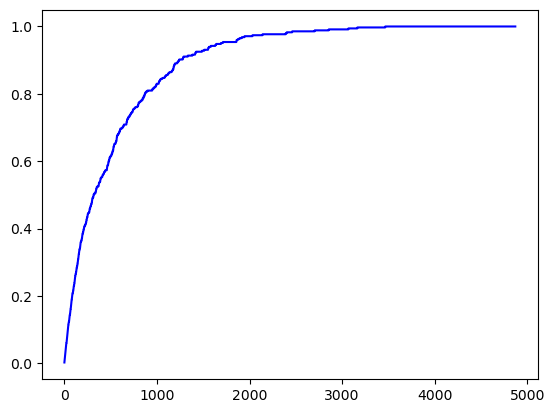

In [25]:
df = review_dic_merged['Prog3']
df_sort = df.sort_values(by='ranking_average_logistic_tfidf', ascending=True) 
labels = df_sort['label_ta_included']
 
labels_series = pd.Series(labels)
total_ones = labels_series.sum()
cumulative_sum = labels_series.cumsum()
proportion_ones = cumulative_sum / total_ones
proportion_ones
plt.plot(range(0, len(df)), proportion_ones, label='Line plot', color='blue') 

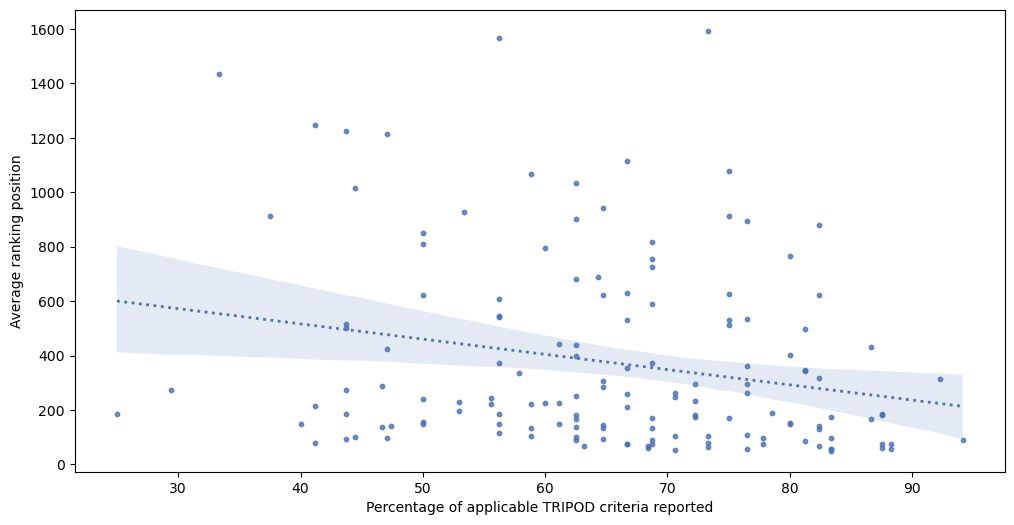

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_plot1 = df[df['label_ft_included'] == 1].copy()

# Choose a variable for the y-axis (replace 'Some_Column' with your actual column name)
x_variables = ['percentage_reported'#,
#                '1i', '1ii', '1iii', '1iv',
#                '2i', '2ii', '2iii', '2iv',
#                '2v', '2vi', '2vii', '2viii',
#                '2ix', '2x', '2xi', '2xii'
] 
y_variables = [#'ranking_average_svm_tfidf',
               #'ranking_average_nb_tfidf',
               #'ranking_average_svm_sbert',
               #'ranking_average_logistic_sbert',
                'ranking_average_logistic_tfidf'
]

for x_var in x_variables:
    
    for y_var in y_variables:
    
        y = df[y_var]
        x = df[x_var]
        
        # Scatter plot with automatic trend line
        plt.figure(figsize=(12,6))
        sns.regplot(x=x, y=y, scatter=True, scatter_kws={"s": 10, "color": sns.color_palette("deep")[0]},
                    line_kws={"linewidth": 2, "linestyle": "dotted", "color": sns.color_palette("deep")[0]})
        
        plt.ylabel("Average ranking position")
        plt.xlabel("Percentage of applicable TRIPOD criteria reported")
        plt.show()


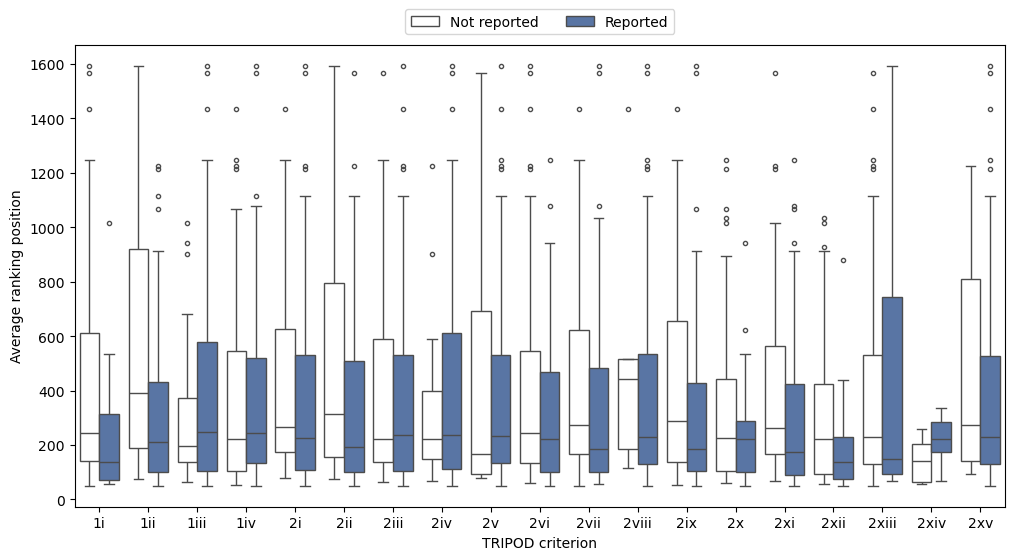

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_plot2 = df.copy()

#TODO check NaN values and add in plot

# Select 'ranking_average_logistic_tfidf' and columns that start with '1' or '2'
selected_columns = ['ranking_average_logistic_tfidf'] + list(df_plot2.filter(regex='^(1|2)'))

# Select those columns
df_selected = df_plot2[selected_columns]

# Reshape from wide to long format
df_melted = df_selected.melt(id_vars='ranking_average_logistic_tfidf', var_name='item', value_name='value')

# Convert the ranking to numeric values for plotting
df_melted['ranking_average_logistic_tfidf'] = pd.to_numeric(df_melted['ranking_average_logistic_tfidf'])

# Create the boxplot
custom_palette = {0: "white", 1: sns.color_palette("deep")[0]} 
plt.figure(figsize=(12, 6))
sns.boxplot(x="item", y="ranking_average_logistic_tfidf", hue="value", data=df_melted,
            palette=custom_palette,
            flierprops={"marker": "o", "markersize": 3})

# Customize the labels
plt.ylabel("Average ranking position")
plt.xlabel("TRIPOD criterion")

# Add the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles=handles, 
    labels=['Not reported', 'Reported'],
    bbox_to_anchor=(0.5, 1.05),  
    loc='center',  
    borderaxespad=0.,
    ncol=2  
)

plt.show()
